In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as pl
import qnm_filter
import qnm
import astropy.constants as c
from scipy.special import logsumexp
T_MSUN = c.M_sun.value * c.G.value / c.c.value**3

In [3]:
srate = 4096*4
t_range=np.arange(-1,1,1/srate)
input = dict(model_list = [(2,2,0, 'p')],
             t_init = 0,
             segment_length = 0.2,
             srate = 4096*4,
             ra = None, dec = None,)

# Fixed injected values

## NNI - fixed M, chi

In [4]:
SNR_arr = []
likelihood_arr = []
N = 10

for i in range(N):
    injected = [50, 0.7]
    omega220=qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=injected[1])[0]
    mass = qnm_filter.Filter.mass_unit(injected[0])
    signal= np.real(np.exp(-1j*omega220*abs(t_range)/(injected[0]*T_MSUN)))
    waveform = qnm_filter.RealData(signal, index=t_range)
    
    fit = qnm_filter.Network(**input)
    fit.original_data['H1'] = waveform
    fit.detector_alignment()
    fit.compute_acfs('original_data')
    temp_acf = np.full(input['srate'], 0, dtype = np.double)
    temp_acf[0] = ((i+1)/N)**2
    fit.acfs['H1'] = qnm_filter.RealData(temp_acf, index = fit.acfs['H1'].index)
    fit.cholesky_decomposition()
    fit.first_index()

    template = fit.truncate_data(fit.original_data)['H1']
    SNR = fit.compute_SNR(None, template, 'H1', optimal=True)
    likelihood220 = fit.likelihood_vs_mass_spin(injected[0]-10, injected[1]-0.4, model_list=[(2,2,0,'p')])
    likelihood221 = fit.likelihood_vs_mass_spin(injected[0]-10, injected[1]-0.4, model_list=[(2,2,1,'p')])
    #Scaling works for any M, chi - doesn't have to be injected one

    SNR_arr.append(SNR)
    likelihood_arr.append(likelihood221 - likelihood220)

Text(0, 0.5, 'log$_{10}(-\\mathcal{L}_{220}$)')

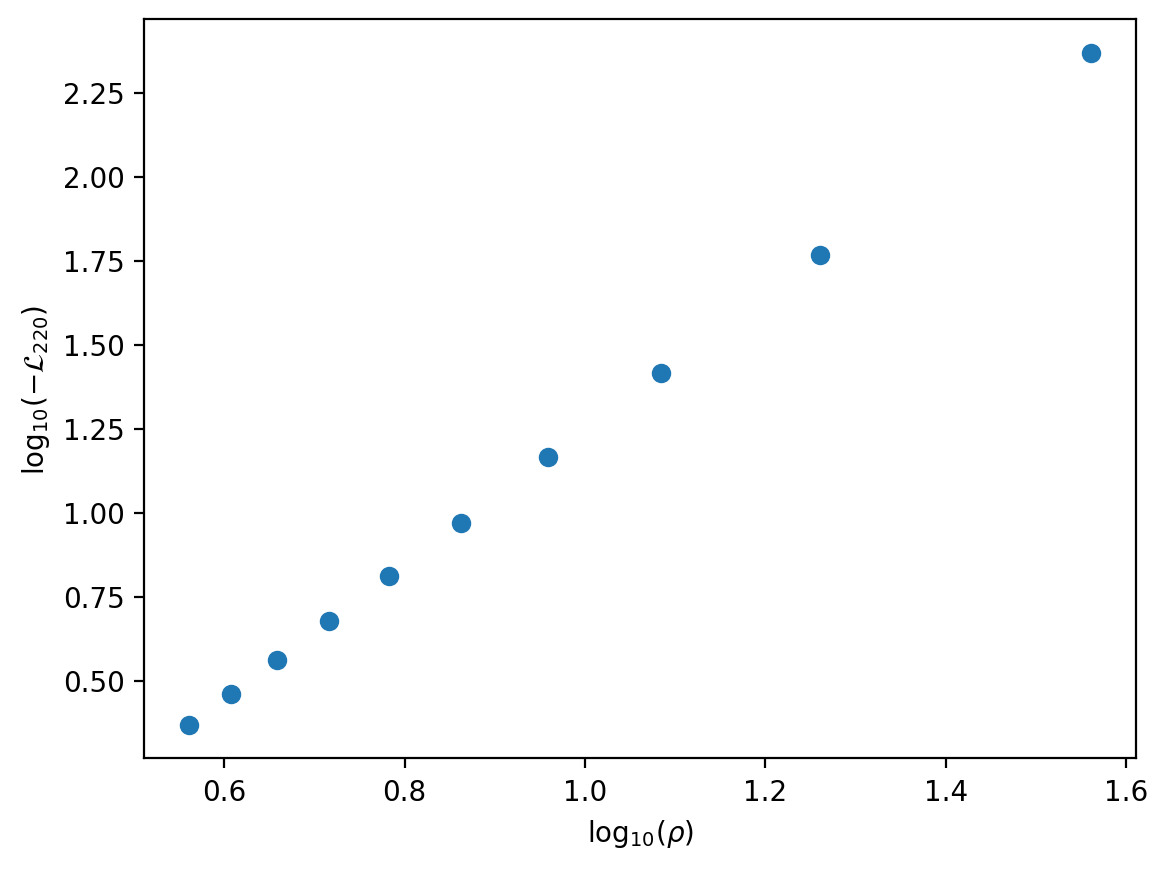

In [5]:
pl.plot(np.log10(SNR_arr), np.log10(np.multiply(-1, likelihood_arr)), 'o')
pl.xlabel(r'log$_{10}(\rho$)')
pl.ylabel(r'log$_{10}(-\mathcal{L}_{220}$)')
# pl.text(0.6, 2.05, 'Slope = 2')

In [6]:
np.polyfit(np.log10(SNR_arr), np.log10(np.multiply(-1, likelihood_arr)),deg=1, cov=True)

(array([ 2.       , -0.7541839]),
 array([[ 2.74397312e-31, -2.48454228e-31],
        [-2.48454228e-31,  2.49992012e-31]]))

## White noise injection - fixed M, chi

In [7]:
SNR_arr = []
likelihood_arr = []
N = 50
std_arr = np.linspace(0.01, 0.1, N)
acf_arr = []

for i in range(N):
    injected = [50, 0.7]
    mass = qnm_filter.Filter.mass_unit(injected[0])
    signal= np.real(np.exp(-1j*omega220*abs(t_range)/(injected[0]*T_MSUN)))
    noise = np.random.normal(0, std_arr[i], len(signal))
    waveform = qnm_filter.RealData(signal+noise, index=t_range)
    
    fit = qnm_filter.Network(**input)
    fit.original_data['H1'] = waveform
    fit.detector_alignment()
    fit.pure_noise = {}
    fit.pure_noise['H1'] = qnm_filter.RealData(noise, index = t_range)
    fit.compute_acfs('pure_noise')
    fit.cholesky_decomposition()
    fit.first_index()
    likelihood220 = fit.likelihood_vs_mass_spin(injected[0], injected[1], model_list=[(2,2,0,'p')])
    likelihood221 = fit.likelihood_vs_mass_spin(injected[0], injected[1], model_list=[(2,2,1,'p')])

    fit_opt = qnm_filter.Network(**input)
    fit_opt.original_data['H1'] = qnm_filter.RealData(signal, index=t_range) #without noise
    fit_opt.detector_alignment()
    fit_opt.first_index()
    template = fit_opt.truncate_data(fit_opt.original_data)['H1']
    data = fit.truncate_data(fit.original_data)['H1']
    SNR = fit.compute_SNR(data, template, 'H1', optimal=False)

    SNR_arr.append(SNR)
    likelihood_arr.append(likelihood221 - likelihood220)

Text(0, 0.5, 'log$_{10}(-\\mathcal{L}_{220}$)')

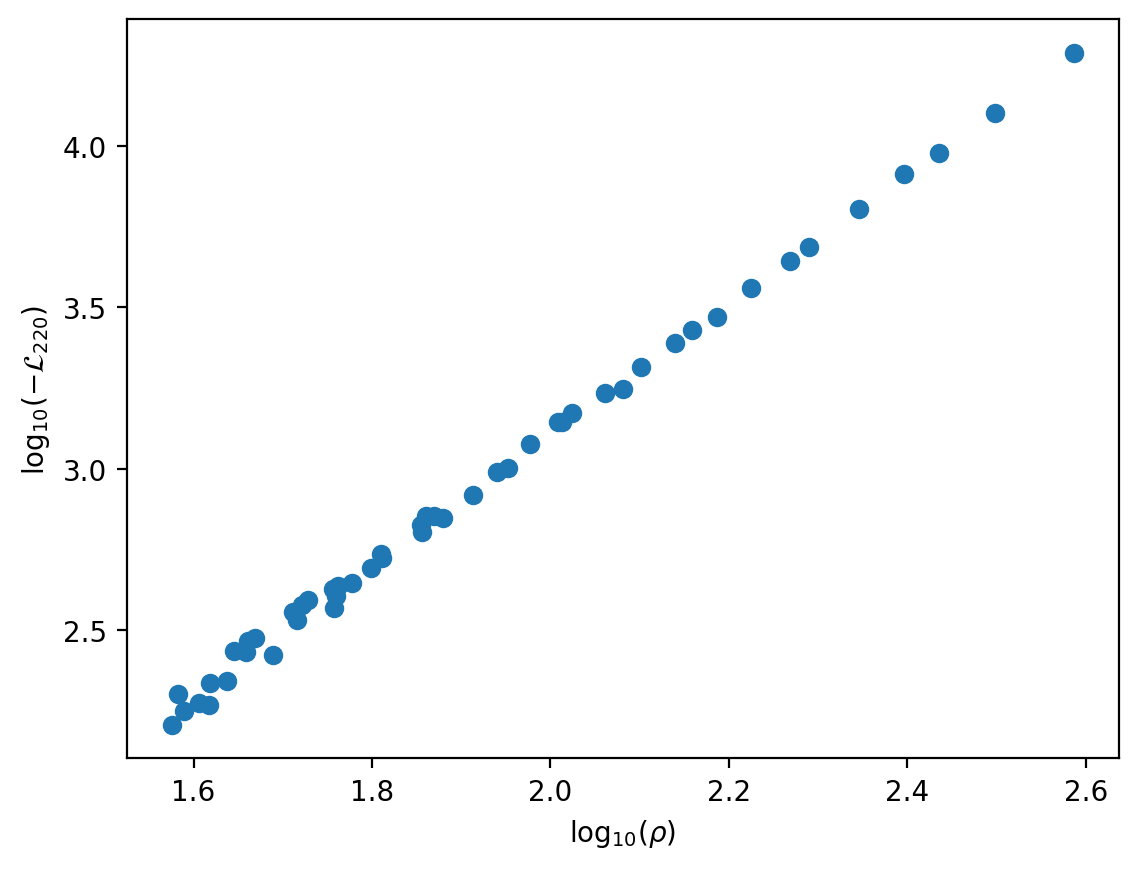

In [8]:
pl.plot(np.log10(SNR_arr), np.log10(np.multiply(-1, likelihood_arr)), 'o')
pl.xlabel(r'log$_{10}(\rho$)')
pl.ylabel(r'log$_{10}(-\mathcal{L}_{220}$)')
# pl.text(0.6, 2.05, 'Slope = 2')

In [181]:
np.polyfit(np.log10(SNR_arr), np.log10(np.multiply(-1, likelihood_arr)),deg=1, cov=True)

(array([ 2.0075368 , -0.92019709]),
 array([[ 9.38682467e-05, -1.79435152e-04],
        [-1.79435152e-04,  3.49438616e-04]]))

## BILBY coloured noise

In [156]:
input['srate'] = 4096

In [159]:
SNR_arr = []
likelihood_arr = []
N = 10
std_arr = np.linspace(0.01, 0.1, N)

for i in range(N):
    injected = [50, 0.7]
    mass = qnm_filter.Filter.mass_unit(injected[0])
    signal= np.real(np.exp(-1j*omega220*abs(t_range)/(injected[0]*T_MSUN)))
    bilby_ifo = qnm_filter.set_bilby_predefined_ifo('H1', srate, 2, start_time=-1)
    noise = qnm_filter.bilby_get_strain(bilby_ifo, time_offset=0)
    noise *= std_arr[i] / np.std(noise)
    waveform = qnm_filter.RealData(signal+noise, index=t_range)
    
    fit = qnm_filter.Network(**input)
    fit.original_data['H1'] = waveform
    fit.pure_noise = {}
    fit.pure_noise['H1'] = qnm_filter.RealData(noise, index = t_range)
    fit.detector_alignment()
    fit.condition_data('pure_noise')
    fit.condition_data('original_data')
    fit.compute_acfs('pure_noise')
    fit.cholesky_decomposition()
    fit.first_index()
    likelihood220 = fit.likelihood_vs_mass_spin(injected[0], injected[1], model_list=[(2,2,0,'p')])
    likelihood221 = fit.likelihood_vs_mass_spin(injected[0], injected[1], model_list=[(2,2,1,'p')])
    
    fit_opt = qnm_filter.Network(**input)
    fit_opt.original_data['H1'] = qnm_filter.RealData(signal, index=t_range) #without noise
    fit_opt.detector_alignment()
    fit_opt.condition_data("original_data")
    fit_opt.first_index()
    template = fit_opt.truncate_data(fit_opt.original_data)['H1']
    data = fit.truncate_data(fit.original_data)['H1']
    SNR = fit.compute_SNR(data, template, 'H1', optimal=False)

    SNR_arr.append(SNR)
    likelihood_arr.append(likelihood221 - likelihood220)

Text(0, 0.5, 'log$_{10}(-\\mathcal{L}_{220}$)')

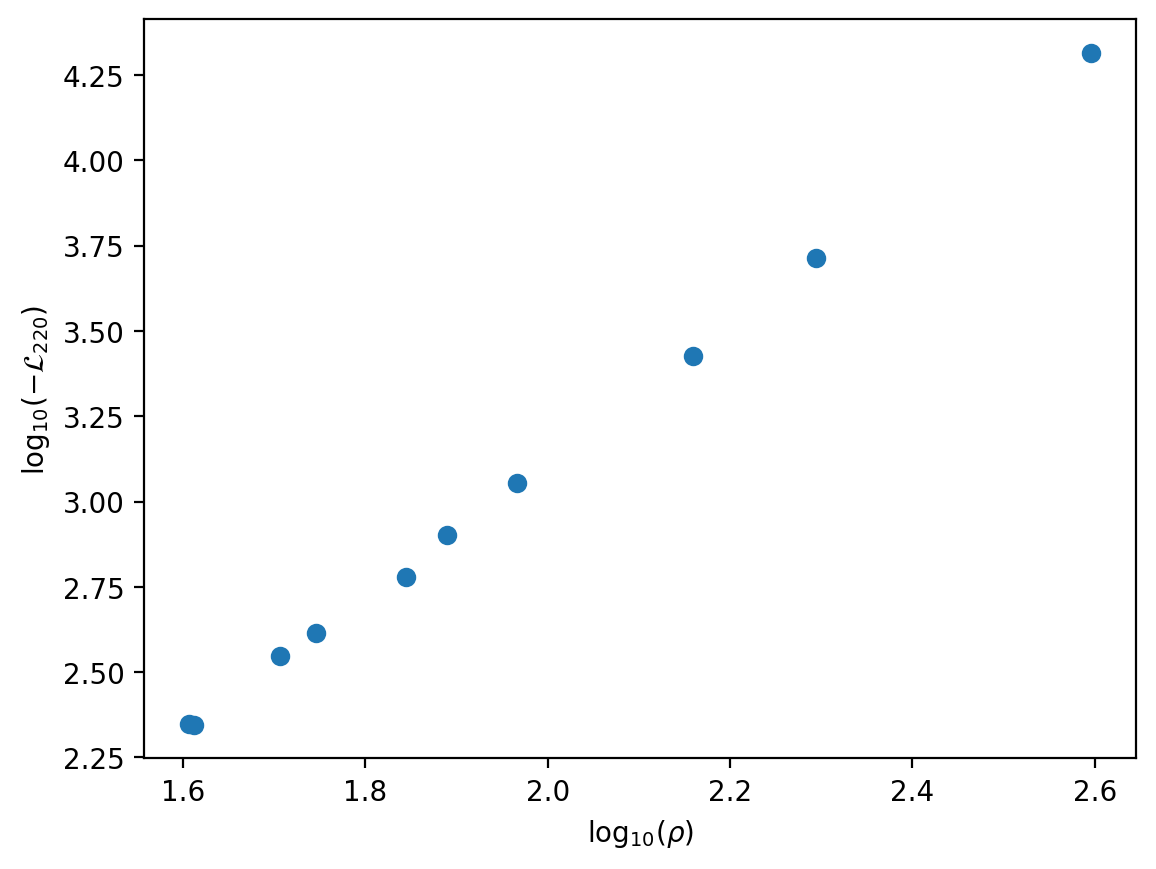

In [160]:
pl.plot(np.log10(SNR_arr), np.log10(np.multiply(-1, likelihood_arr)), 'o')
pl.xlabel(r'log$_{10}(\rho$)')
pl.ylabel(r'log$_{10}(-\mathcal{L}_{220}$)')
# pl.text(0.6, 2.05, 'Slope = 2')

In [161]:
np.polyfit(np.log10(SNR_arr), np.log10(np.multiply(-1, likelihood_arr)),deg=1, cov=True)

(array([ 1.99425853, -0.86902846]),
 array([[ 0.00019768, -0.00038396],
        [-0.00038396,  0.00076409]]))

# Random mass and spin 

## NNI

In [12]:
SNR_arr = []
likelihood_arr = []
input['srate'] = 4096*4

for i in range(10):
    injected = [np.random.uniform(45, 150, 1)[0], np.random.uniform(0, 0.85, 1)[0]]
    omega220=qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=injected[1])[0]
    mass = qnm_filter.Filter.mass_unit(injected[0])
    signal= np.real(np.exp(-1j*omega220*abs(t_range)/(injected[0]*T_MSUN)))
    padded = qnm_filter.pad_data_for_fft(qnm_filter.RealData(signal, index=t_range), 2,2)
    waveform = qnm_filter.RealData(padded[1], index=padded[0])
    
    fit = qnm_filter.Network(**input)
    fit.original_data['H1'] = waveform
    fit.detector_alignment()
    fit.compute_acfs('original_data')
    temp_acf = np.full(input['srate'], 0, dtype = np.double)
    temp_acf[0] = np.random.uniform(0.1, 0.1, 1)[0]**2
    fit.acfs['H1'] = qnm_filter.RealData(temp_acf, index = fit.acfs['H1'].index)
    fit.cholesky_decomposition()
    fit.first_index()

    template = fit.truncate_data(fit.original_data)['H1']
    SNR = fit.compute_SNR(None, template, 'H1', optimal=True)

    filt220_likelihood = fit.likelihood_vs_mass_spin(injected[0], injected[1], model_list=[(2,2,0,'p')])
    nofilter = fit.compute_likelihood(apply_filter=False)

    SNR_arr.append(SNR)
    likelihood_arr.append(filt220_likelihood - nofilter)

In [16]:
np.polyfit(np.log10(SNR_arr), np.log10(np.multiply(1, likelihood_arr)),deg=1, cov=True)

(array([ 2.     , -0.30103]),
 array([[ 3.73316183e-20, -6.40259832e-20],
        [-6.40259832e-20,  1.09948964e-19]]))

Text(0.5, 1.0, 'Randomly chosen mass and chi')

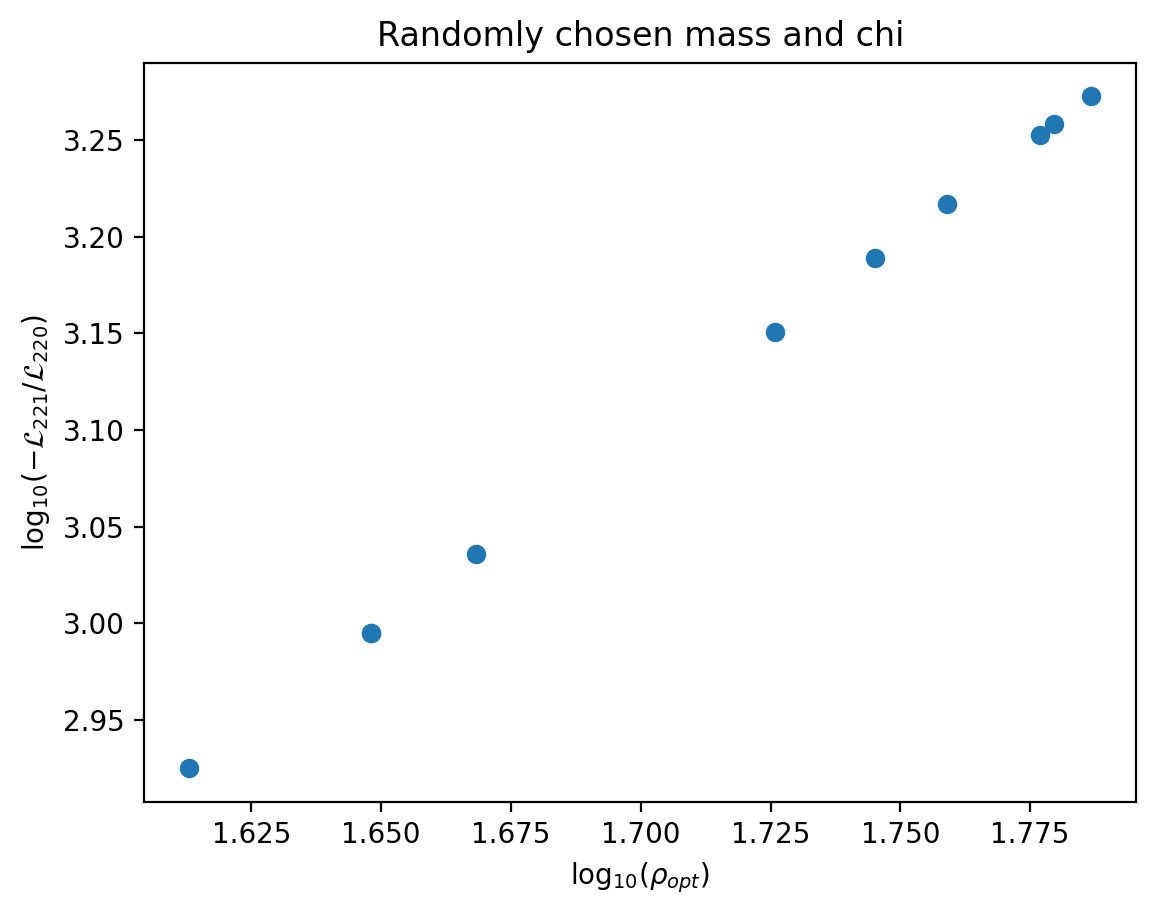

In [17]:
pl.plot(np.log10(SNR_arr), np.log10(np.multiply(1, likelihood_arr)), 'o')
pl.xlabel(r'log$_{10}(\rho_{opt}$)')
pl.ylabel(r'log$_{10}(-\mathcal{L}_{221}/\mathcal{L}_{220}$)')
# pl.text(1.56, -7.75, 'Slope = -8.21')
pl.title("Randomly chosen mass and chi")

## White noise, coverage test

In [214]:
SNR_arr = []
likelihood_arr = []
N = 10
std_arr = np.linspace(0.01, 0.1, N)
input['srate'] = 4096*4

for i in range(N):
    injected = [np.random.uniform(45, 150, 1)[0], np.random.uniform(0, 0.85, 1)[0]]
    omega220=qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=injected[1])[0]
    mass = qnm_filter.Filter.mass_unit(injected[0])
    signal= np.real(np.exp(-1j*omega220*abs(t_range)/(injected[0]*T_MSUN)))
    noise = np.random.normal(0, std_arr[i], len(signal))
    waveform = qnm_filter.RealData(signal+noise, index=t_range)
    
    fit = qnm_filter.Network(**input)
    fit.original_data['H1'] = waveform
    fit.detector_alignment()
    fit.pure_noise = {}
    fit.pure_noise['H1'] = qnm_filter.RealData(noise, index = t_range)
    fit.compute_acfs('pure_noise')
    fit.cholesky_decomposition()
    fit.first_index()
    likelihood220 = fit.likelihood_vs_mass_spin(injected[0], injected[1], model_list=[(2,2,0,'p')])
    likelihood221 = fit.likelihood_vs_mass_spin(injected[0], injected[1], model_list=[(2,2,1,'p')])

    fit_opt = qnm_filter.Network(**input)
    fit_opt.original_data['H1'] = qnm_filter.RealData(signal, index=t_range) #without noise
    fit_opt.detector_alignment()
    fit_opt.first_index()
    template = fit_opt.truncate_data(fit_opt.original_data)['H1']
    data = fit.truncate_data(fit.original_data)['H1']
    SNR = fit.compute_SNR(data, template, 'H1', optimal=False)

    SNR_arr.append(SNR)
    likelihood_arr.append(likelihood221 - likelihood220)

Text(0, 0.5, 'log$_{10}(-\\mathcal{L}_{220}$)')

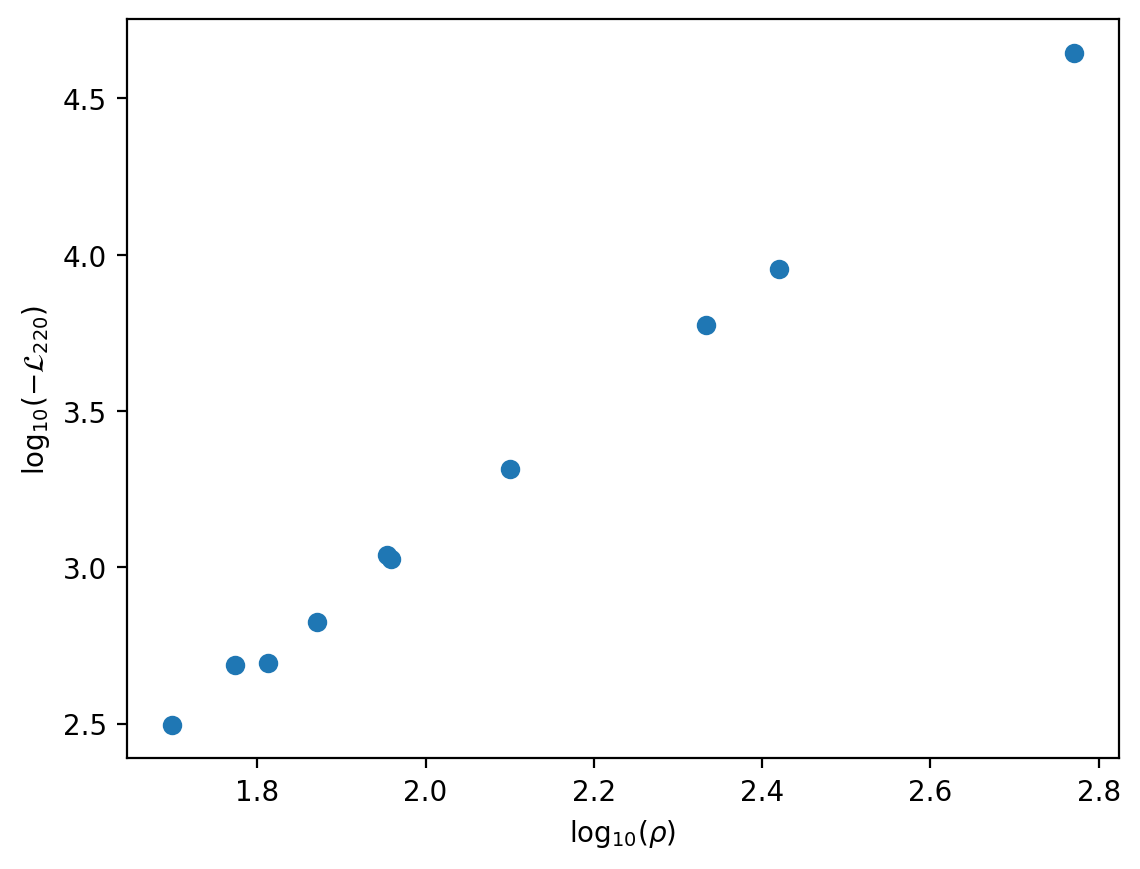

In [215]:
pl.plot(np.log10(SNR_arr), np.log10(np.multiply(-1, likelihood_arr)), 'o')
pl.xlabel(r'log$_{10}(\rho_{opt}$)')
pl.ylabel(r'log$_{10}(-\mathcal{L}_{221}/\mathcal{L}_{220}$)')
# pl.text(0.6, 2.05, 'Slope = 2')

In [216]:
np.polyfit(np.log10(SNR_arr), np.log10(np.multiply(-1, likelihood_arr)),deg=1, cov=True)

(array([ 2.00725317, -0.90787804]),
 array([[ 0.00045386, -0.0009392 ],
        [-0.0009392 ,  0.00199074]]))

## Coloured noise

In [217]:
input['srate'] = 4096
SNR_arr = []
likelihood_arr = []
N = 50

for i in range(N):
    injected = [np.random.uniform(30, 150, 1)[0], np.random.uniform(0.2, 0.7, 1)[0]]
    omega220=qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=injected[1])[0]
    mass = qnm_filter.Filter.mass_unit(injected[0])
    signal= np.real(np.exp(-1j*omega220*abs(t_range)/(injected[0]*T_MSUN)))
    bilby_ifo = qnm_filter.set_bilby_predefined_ifo('H1', srate, 2, start_time=-1)
    noise = qnm_filter.bilby_get_strain(bilby_ifo, time_offset=0)
    noise *= np.random.uniform(0.01, 0.7, 1)[0] / np.std(noise)
    waveform = qnm_filter.RealData(signal+noise, index=t_range)
    
    fit = qnm_filter.Network(**input)
    fit.original_data['H1'] = waveform
    fit.pure_noise = {}
    fit.pure_noise['H1'] = qnm_filter.RealData(noise, index = t_range)
    fit.detector_alignment()
    fit.condition_data('pure_noise')
    fit.condition_data('original_data')
    fit.compute_acfs('pure_noise')
    fit.cholesky_decomposition()
    fit.first_index()
    likelihood220 = fit.likelihood_vs_mass_spin(injected[0], injected[1], model_list=[(2,2,0,'p')])
    likelihood221 = fit.likelihood_vs_mass_spin(injected[0], injected[1], model_list=[(2,2,1,'p')])
    
    fit_opt = qnm_filter.Network(**input)
    fit_opt.original_data['H1'] = qnm_filter.RealData(signal, index=t_range) #without noise
    fit_opt.detector_alignment()
    fit_opt.condition_data("original_data")
    fit_opt.first_index()
    template = fit_opt.truncate_data(fit_opt.original_data)['H1']
    data = fit.truncate_data(fit.original_data)['H1']
    SNR = fit.compute_SNR(data, template, 'H1', optimal=False)

    SNR_arr.append(SNR)
    likelihood_arr.append(likelihood221 - likelihood220)

Text(0, 0.5, 'log$_{10}(-\\mathcal{L}_{221}/\\mathcal{L}_{220}$)')

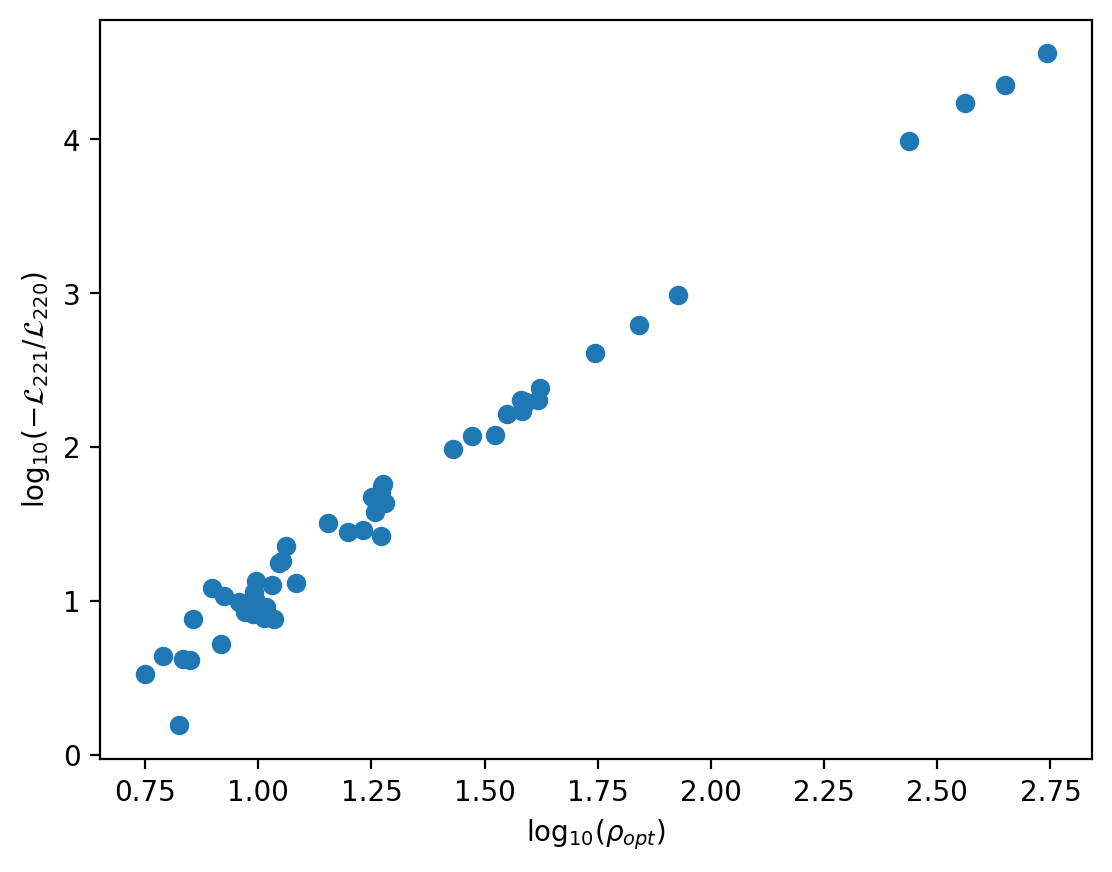

In [220]:
pl.plot(np.log10(SNR_arr), np.log10(np.multiply(-1, likelihood_arr)), 'o')
pl.xlabel(r'log$_{10}(\rho_{opt}$)')
pl.ylabel(r'log$_{10}(-\mathcal{L}_{221}/\mathcal{L}_{220}$)')
# pl.text(0.6, 2.05, 'Slope = 2')

In [219]:
np.polyfit(np.log10(SNR_arr), np.log10(np.multiply(-1, likelihood_arr)),deg=1, cov=True)

(array([ 2.06067372, -1.01470397]),
 array([[ 0.00136855, -0.00179222],
        [-0.00179222,  0.00265696]]))

## Multiple modes wrong

In [8]:
input['srate'] = 4096
SNR_arr = []
likelihood_arr = []
likelihood_arr1 = []
N = 50

for i in range(N):
    injected = [np.random.uniform(30, 150, 1)[0], np.random.uniform(0.2, 0.7, 1)[0]]
    omega220 = qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=injected[1])[0]
    omega221 = qnm.modes_cache(s=-2,l=2,m=2,n=1)(a=injected[1])[0]
    rand_amp = 0.5
    signal220 = rand_amp*np.real(np.exp(-1j*omega220*abs(t_range)/(injected[0]*T_MSUN)))
    signal221 = (1-rand_amp)*np.real(np.exp(-1j*omega221*abs(t_range)/(injected[0]*T_MSUN)))
    signal = signal220+signal221
    bilby_ifo = qnm_filter.set_bilby_predefined_ifo('H1', srate, 2, start_time=-1)
    noise = qnm_filter.bilby_get_strain(bilby_ifo, time_offset=0)
    noise *= np.random.uniform(0.01, 0.1, 1)[0] / np.std(noise)
    waveform = qnm_filter.RealData(signal+noise, index=t_range)
    
    fit = qnm_filter.Network(**input)
    fit.original_data['H1'] = waveform
    fit.pure_noise = {}
    fit.pure_noise['H1'] = qnm_filter.RealData(noise, index = t_range)
    fit.detector_alignment()
    fit.condition_data('pure_noise')
    fit.condition_data('original_data')
    fit.compute_acfs('pure_noise')
    fit.cholesky_decomposition()
    fit.first_index()
    likelihood2201 = fit.likelihood_vs_mass_spin(injected[0], injected[1], model_list=[(2,2,0,'p'), (2,2,1,'p')])
    likelihood220 = fit.likelihood_vs_mass_spin(injected[0], injected[1], model_list=[(2,2,0,'p')])
    likelihood221 = fit.likelihood_vs_mass_spin(injected[0], injected[1], model_list=[(2,2,1,'p')])
    
    fit_opt = qnm_filter.Network(**input)
    fit_opt.original_data['H1'] = qnm_filter.RealData(signal, index=t_range) #without noise
    fit_opt.detector_alignment()
    fit_opt.condition_data("original_data")
    fit_opt.first_index()
    template = fit_opt.truncate_data(fit_opt.original_data)['H1']
    data = fit.truncate_data(fit.original_data)['H1']
    SNR = fit.compute_SNR(data, template, 'H1', optimal=True)

    SNR_arr.append(SNR)
    likelihood_arr.append(likelihood220 - likelihood221)
    likelihood_arr1.append(likelihood2201 - likelihood220)

In [11]:
np.polyfit(np.log10(SNR_arr), np.log10(likelihood_arr1),deg=1)

array([ 1.92362552, -1.60089148])

Text(0, 0.5, 'log$_{10}(-ln(BF(221/220)))$')

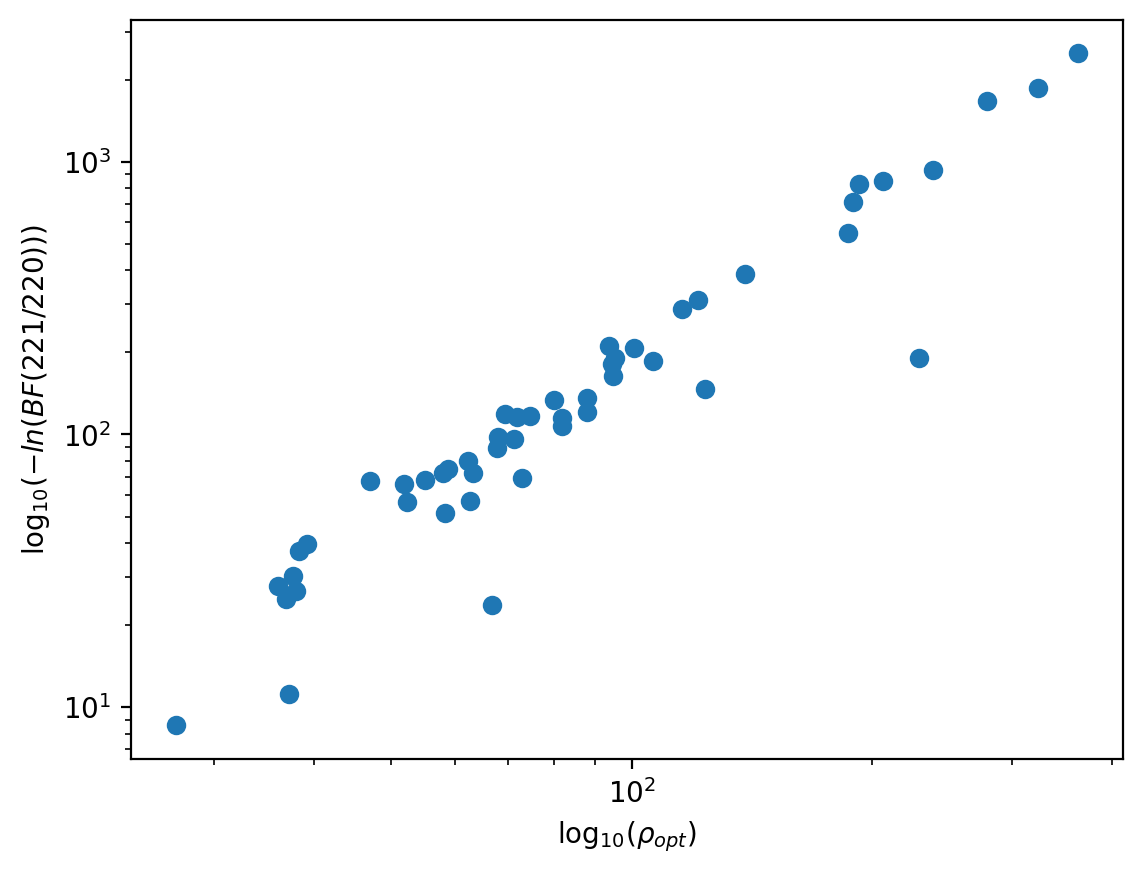

In [10]:
pl.loglog(SNR_arr, likelihood_arr1, 'o')
pl.xlabel(r'log$_{10}(\rho_{opt}$)')
pl.ylabel(r'log$_{10}(-ln(BF(221/220)))$')
# pl.text(0.6, 2.05, 'Slope = 2')

In [11]:
np.polyfit(np.log10(SNR_arr), np.log10(np.multiply(1, likelihood_arr1)),deg=1)

array([ 2.01632359, -0.92454992])

Text(0, 0.5, 'log$_{10}(-ln(BF(221/220)))$')

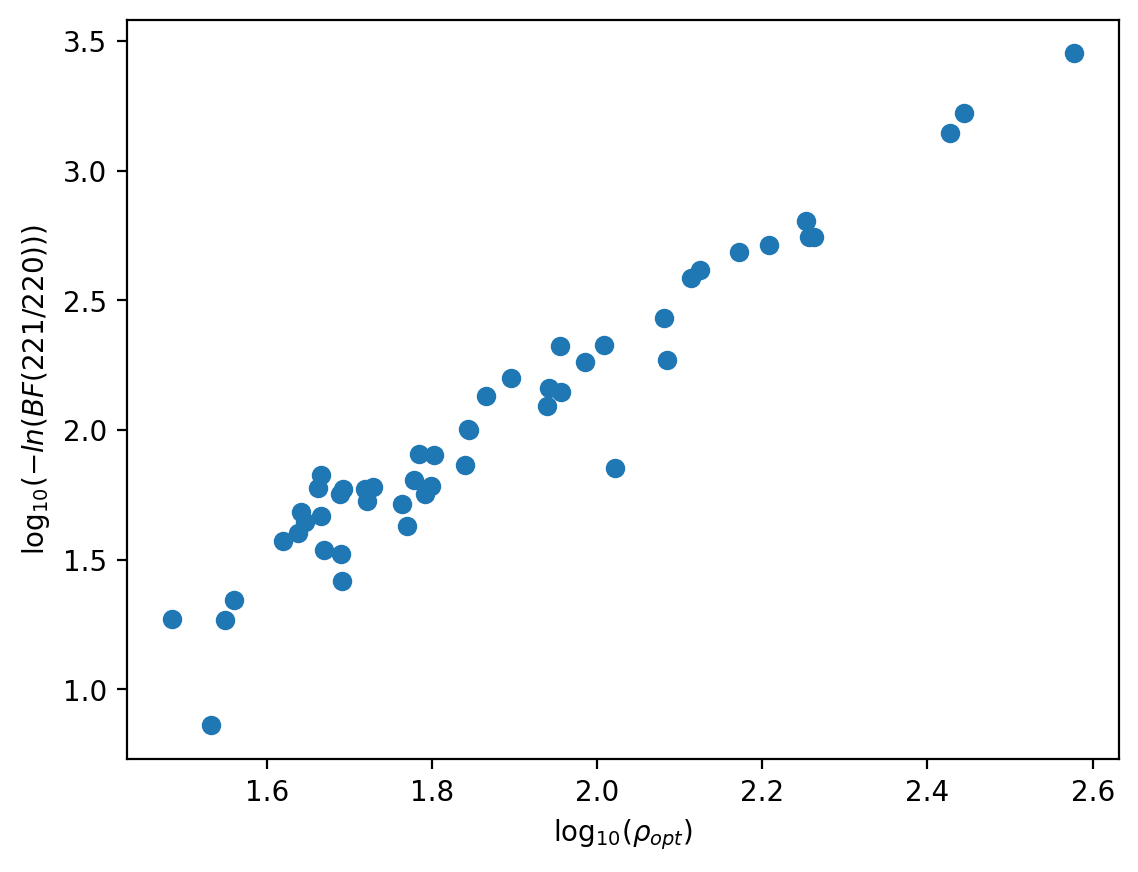

In [28]:
pl.plot(np.log10(SNR_arr), np.log10(np.multiply(1, likelihood_arr1)), 'o')
pl.xlabel(r'log$_{10}(\rho_{opt}$)')
pl.ylabel(r'log$_{10}(-ln(BF(221/220)))$')
# pl.text(0.6, 2.05, 'Slope = 2')

# Evidence

In [19]:
delta_mass = 2.0
delta_chi = 0.03
massspace = np.arange(30, 100, delta_mass)
chispace = np.arange(0.0, 0.95, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

## NNI

In [35]:
N = 20
results = np.empty((N, 5))
input['srate'] = 4096*1

for i in range(N):
    injected = [np.random.uniform(45, 150, 1)[0], np.random.uniform(0, 0.85, 1)[0]]
    omega220 = qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=injected[1])[0]
    omega221 = qnm.modes_cache(s=-2,l=2,m=2,n=1)(a=injected[1])[0]
    signal220 = np.real(np.exp(-1j*omega220*abs(t_range)/(injected[0]*T_MSUN)))
    signal221 = np.real(np.exp(-1j*omega221*abs(t_range)/(injected[0]*T_MSUN)))
#     rand_amp = np.random.uniform(0.7, 1, 1)[0]
    signal = 1*signal220 + 1*signal221
    waveform = qnm_filter.RealData(signal, index=t_range)
    
    fit = qnm_filter.Network(**input)
    fit.original_data['H1'] = waveform
    fit.detector_alignment()
    fit.condition_data('original_data')
    fit.compute_acfs('original_data')
    temp_acf = np.full(input['srate'], 0, dtype = np.double)
    temp_acf[0] = np.random.uniform(0.01, 0.1, 1)[0]**2
    fit.acfs['H1'] = qnm_filter.RealData(temp_acf, index = fit.acfs['H1'].index)
    fit.cholesky_decomposition()
    fit.first_index()
    
    fit.pure_nr = {}
    fit.pure_nr['H1'] = qnm_filter.RealData((1-rand_amp)*signal221, index=t_range)
    fit.condition_data('pure_nr')
    template = fit.truncate_data(fit.pure_nr)['H1']
    SNR = fit.compute_SNR(None, template, 'H1', optimal=True)

    _, evidence220 = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, model_list=[(2,2,0,'p')])
    _, evidence221 = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, model_list=[(2,2,1,'p')])
    _, evidence220_221 = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, 
                                                  model_list=[(2,2,0,'p'),(2,2,1,'p')])
    nofilter = logsumexp(
        np.array(
            [fit.compute_likelihood(apply_filter=False)]
            * len(massspace)
            * len(chispace)
        )
    )

    results[i] = np.array([SNR, nofilter, evidence220, evidence221, evidence220_221])

Text(0, 0.5, 'BF(220+221 / 220)')

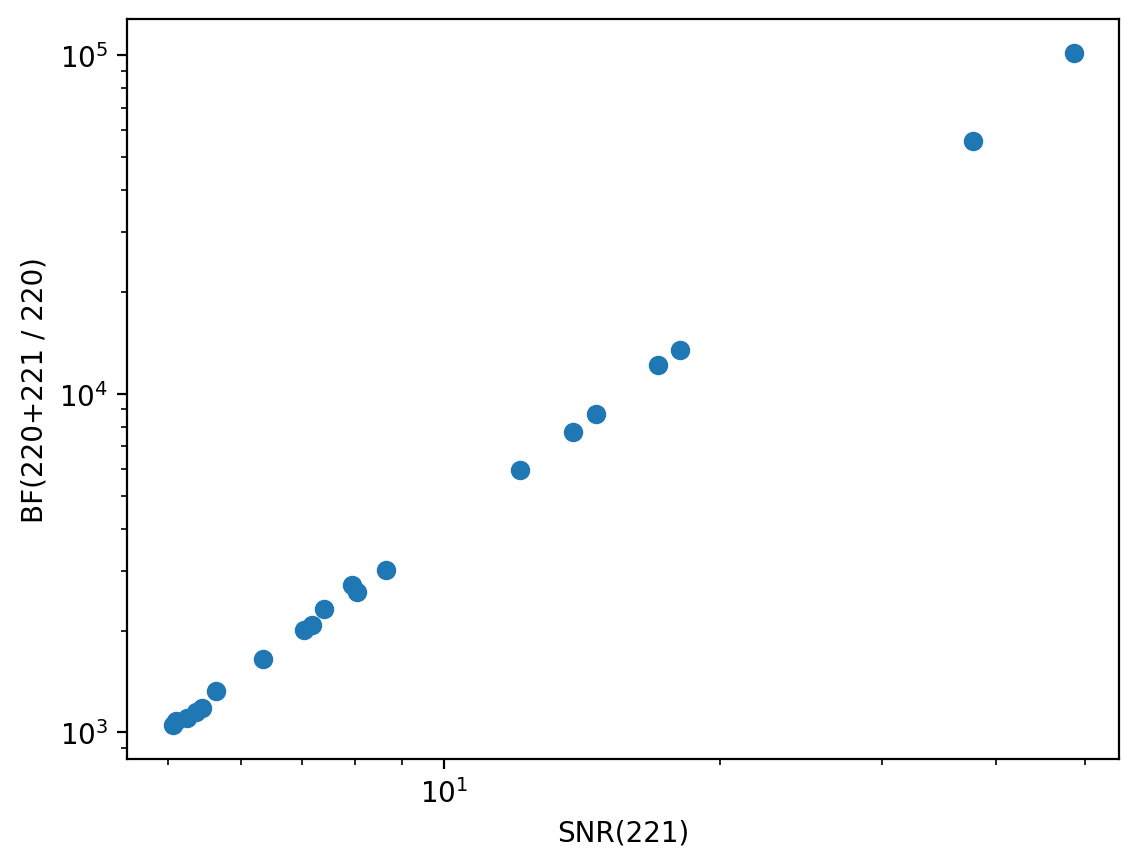

In [39]:
pl.loglog(results[:,0], results[:,4]-results[:,1], 'o')
pl.xlabel("SNR(221)")
pl.ylabel("BF(220+221 / 220)")
# pl.xlim(3, 7)
# pl.ylim(-5, 1)

## Colored noise

## Finer grid

In [350]:
delta_mass = 0.2
delta_chi = 0.01
massspace = np.arange(30, 100, delta_mass)
chispace = np.arange(0.0, 0.95, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

In [351]:
input['srate'] = 4096
SNR_arr = []
bayes_arr = []
N = 10
repeats = 6
std_arr = np.repeat(np.linspace(0.01, 0.1, N), repeats)

for i in std_arr:
    injected = [np.random.uniform(60, 80, 1)[0], np.random.uniform(0.4, 0.6, 1)[0]]
    omega220=qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=injected[1])[0]
    mass = qnm_filter.Filter.mass_unit(injected[0])
    signal= np.real(np.exp(-1j*omega220*abs(t_range)/(injected[0]*T_MSUN)))
    bilby_ifo = qnm_filter.set_bilby_predefined_ifo('H1', srate, 2, start_time=-1)
    noise = qnm_filter.bilby_get_strain(bilby_ifo, time_offset=0)
    noise *= i / np.std(noise)
    waveform = qnm_filter.RealData(signal+noise, index=t_range)
    
    fit = qnm_filter.Network(**input)
    fit.original_data['H1'] = waveform
    fit.pure_noise = {}
    fit.pure_noise['H1'] = qnm_filter.RealData(noise, index = t_range)
    fit.detector_alignment()
    fit.condition_data('pure_noise')
    fit.condition_data('original_data')
    fit.compute_acfs('pure_noise')
    fit.cholesky_decomposition()
    fit.first_index()
    _, evidence220 = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, model_list=[(2,2,0,'p')])
    _, evidence221 = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, model_list=[(2,2,1,'p')])
    
    fit_opt = qnm_filter.Network(**input)
    fit_opt.original_data['H1'] = qnm_filter.RealData(signal, index=t_range) #without noise
    fit_opt.detector_alignment()
    fit_opt.condition_data("original_data")
    fit_opt.first_index()
    template = fit_opt.truncate_data(fit_opt.original_data)['H1']
    data = fit.truncate_data(fit.original_data)['H1']
    SNR = fit.compute_SNR(data, template, 'H1', optimal=False)

    SNR_arr.append(SNR)
    bayes_arr.append(evidence220 - evidence221)

KeyboardInterrupt: 

Text(0, 0.5, 'log$_{10}(-ln(BF(221/220)))$')

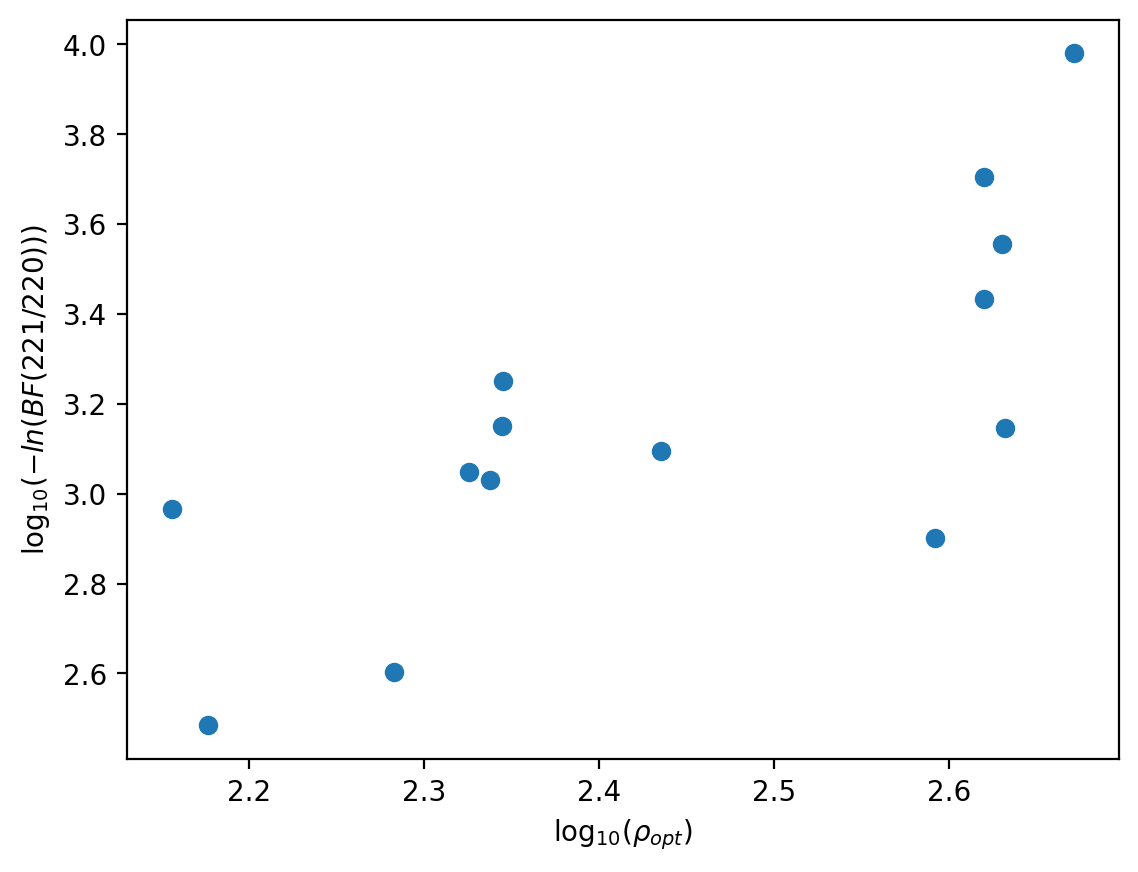

In [352]:
pl.plot(np.log10(SNR_arr), np.log10(bayes_arr), 'o')
pl.xlabel(r'log$_{10}(\rho_{opt}$)')
pl.ylabel(r'log$_{10}(-ln(BF(221/220)))$')
# pl.text(0.6, 2.05, 'Slope = 2')

## Coarser grid

In [ ]:
delta_mass = 2.0
delta_chi = 0.03
massspace = np.arange(30, 100, delta_mass)
chispace = np.arange(0.0, 0.95, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

In [322]:
input['srate'] = 4096
SNR_arr = []
bayes_arr = []
N = 10
repeats = 6
std_arr = np.repeat(np.linspace(0.01, 0.1, N), repeats)

for i in std_arr:
    injected = [np.random.uniform(60, 80, 1)[0], np.random.uniform(0.4, 0.6, 1)[0]]
    omega220=qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=injected[1])[0]
    mass = qnm_filter.Filter.mass_unit(injected[0])
    signal= np.real(np.exp(-1j*omega220*abs(t_range)/(injected[0]*T_MSUN)))
    bilby_ifo = qnm_filter.set_bilby_predefined_ifo('H1', srate, 2, start_time=-1)
    noise = qnm_filter.bilby_get_strain(bilby_ifo, time_offset=0)
    noise *= i / np.std(noise)
    waveform = qnm_filter.RealData(signal+noise, index=t_range)
    
    fit = qnm_filter.Network(**input)
    fit.original_data['H1'] = waveform
    fit.pure_noise = {}
    fit.pure_noise['H1'] = qnm_filter.RealData(noise, index = t_range)
    fit.detector_alignment()
    fit.condition_data('pure_noise')
    fit.condition_data('original_data')
    fit.compute_acfs('pure_noise')
    fit.cholesky_decomposition()
    fit.first_index()
    _, evidence220 = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, model_list=[(2,2,0,'p')])
    _, evidence221 = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, model_list=[(2,2,1,'p')])
    
    fit_opt = qnm_filter.Network(**input)
    fit_opt.original_data['H1'] = qnm_filter.RealData(signal, index=t_range) #without noise
    fit_opt.detector_alignment()
    fit_opt.condition_data("original_data")
    fit_opt.first_index()
    template = fit_opt.truncate_data(fit_opt.original_data)['H1']
    data = fit.truncate_data(fit.original_data)['H1']
    SNR = fit.compute_SNR(data, template, 'H1', optimal=False)

    SNR_arr.append(SNR)
    bayes_arr.append(evidence221 - evidence220)

In [332]:
temp_SNR = np.log10(SNR_arr)
temp_bayes = np.log10(np.multiply(-1, bayes_arr))

In [333]:
median_SNR = np.median(np.reshape(temp_SNR, (N, repeats)), axis=1)
std_SNR = np.std(np.reshape(temp_SNR, (N, repeats)), axis=1)
median_bayes = np.median(np.reshape(temp_bayes, (N, repeats)), axis=1)
std_bayes = np.std(np.reshape(temp_bayes, (N, repeats)), axis=1)

Text(0, 0.5, 'log$_{10}(-ln(BF)')

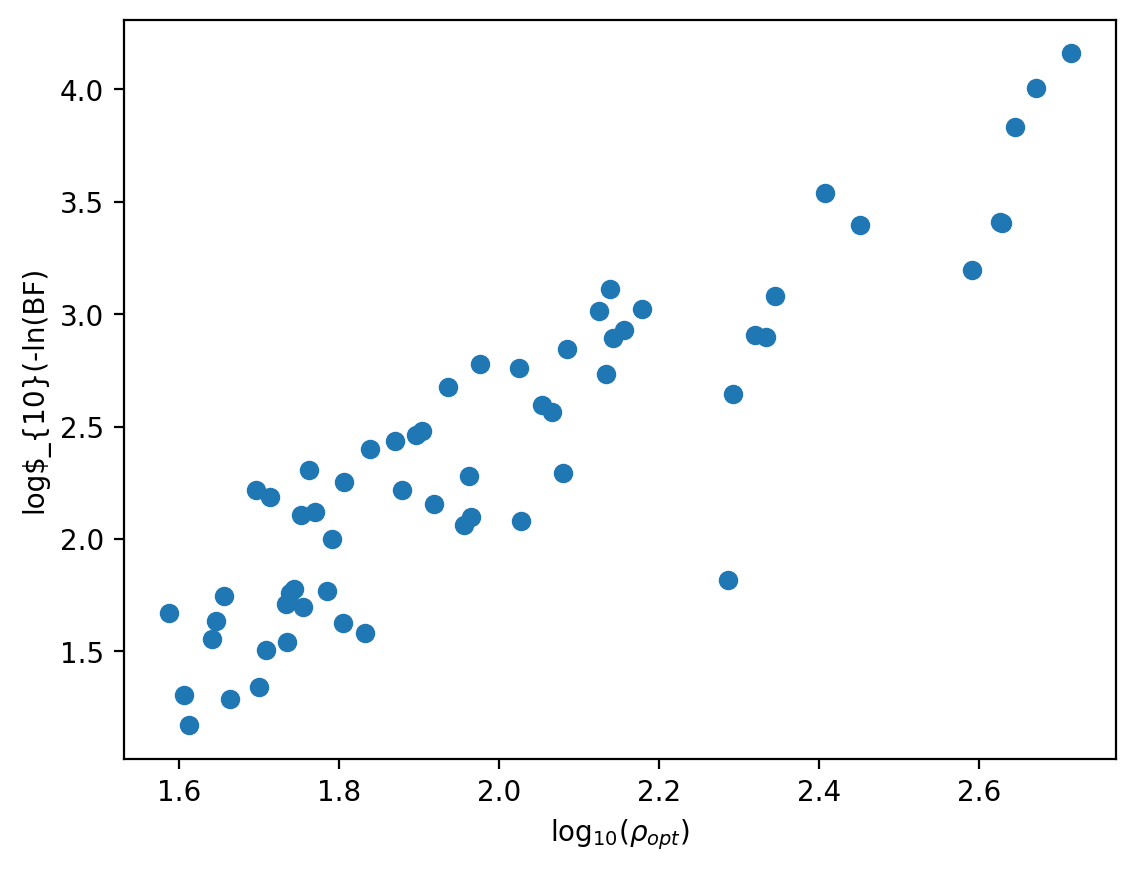

In [340]:
pl.plot(temp_SNR, temp_bayes, 'o')
# pl.fill_between(median_SNR, median_bayes-std_bayes, median_bayes+std_bayes, color='k', alpha=0.2)
pl.xlabel(r'log$_{10}(\rho_{opt}$)')
pl.ylabel(r'log$_{10}(-ln(BF)')
# pl.text(0.6, 2.05, 'Slope = 2')

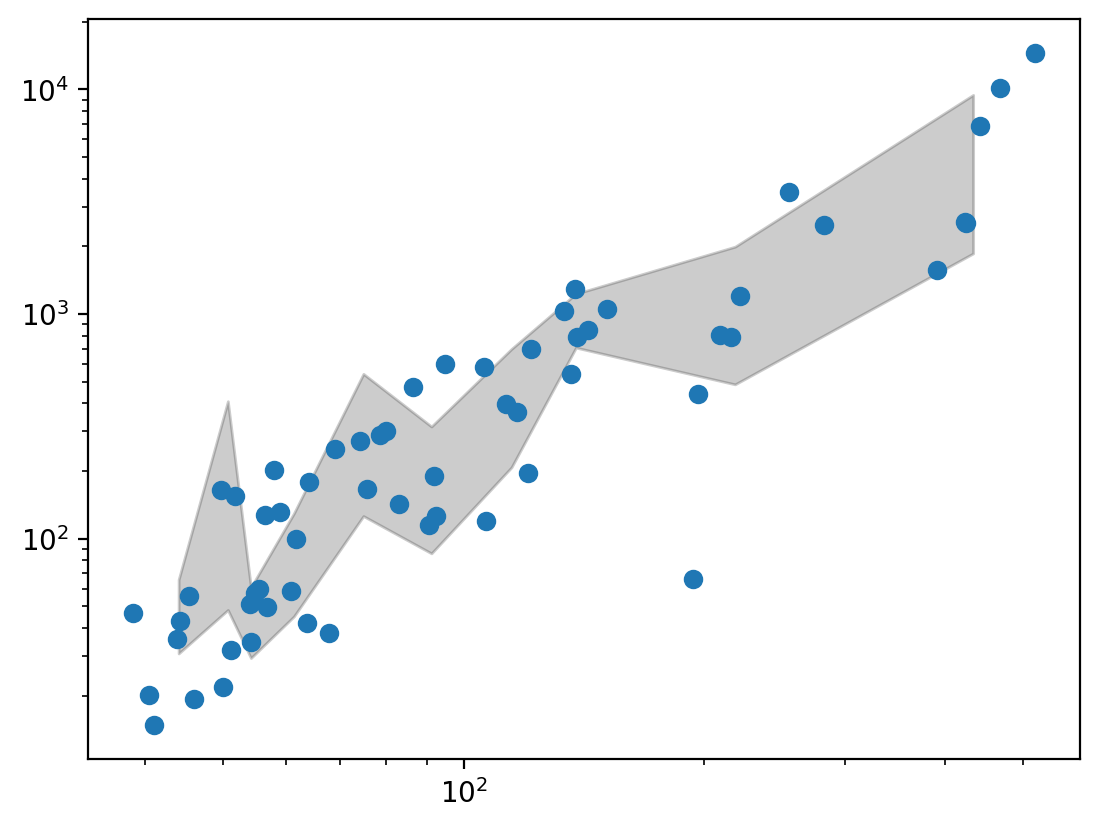

In [348]:
pl.loglog(SNR_arr, np.multiply(-1,bayes_arr), 'o')
pl.fill_between(10**median_SNR, 10**(median_bayes-std_bayes), 10**(median_bayes+std_bayes), color='k', alpha=0.2)


Text(0, 0.5, 'log$_{10}(-ln(BF)')

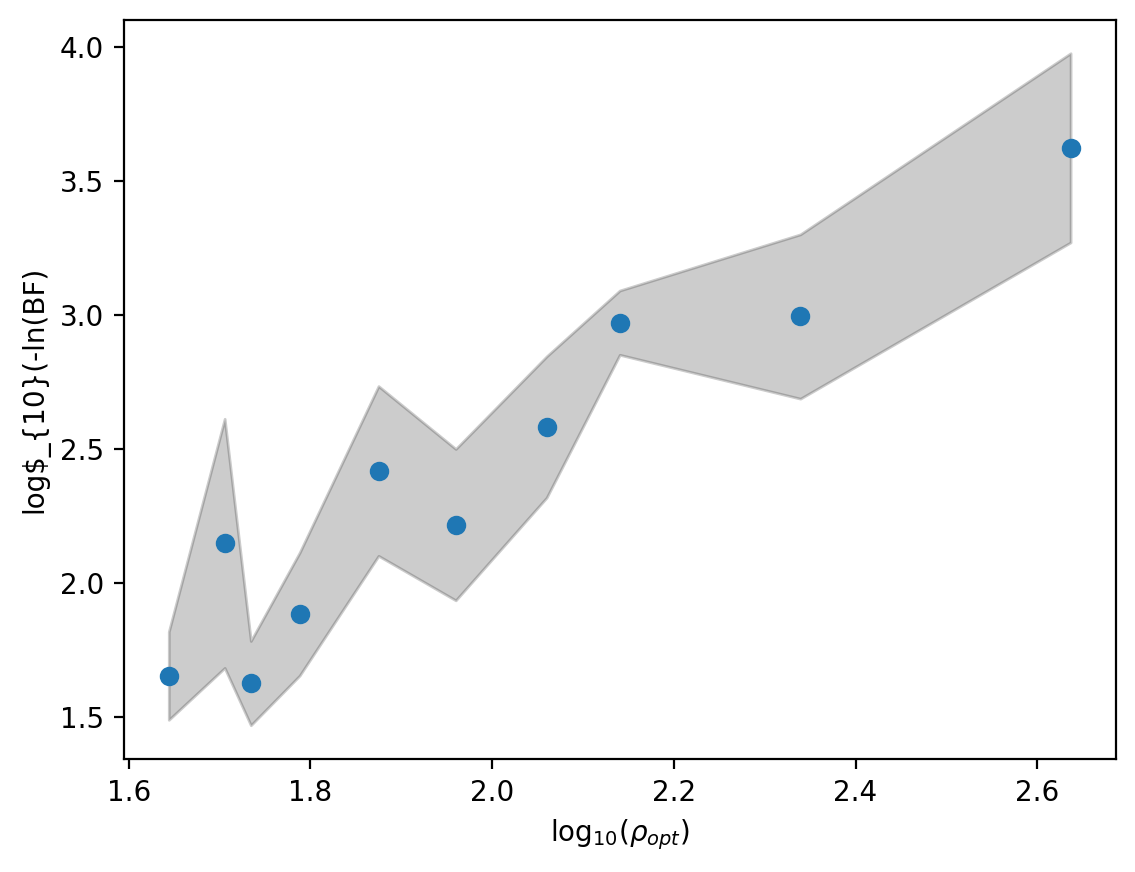

In [339]:
# pl.plot(median_SNR, median_bayes, 'o')
# # pl.fill_between(median_SNR, median_bayes-std_bayes, median_bayes+std_bayes, color='k', alpha=0.2)
# pl.xlabel(r'log$_{10}(\rho_{opt}$)')
# pl.ylabel(r'log$_{10}(-ln(BF)')
# # pl.text(0.6, 2.05, 'Slope = 2')

In [341]:
np.polyfit(median_SNR, median_bayes,deg=1, cov=True)

(array([ 1.94929013, -1.46470622]),
 array([[ 0.04880473, -0.09703878],
        [-0.09703878,  0.19728017]]))

## Multiple modes

In [ ]:
input['srate'] = 4096
SNR_arr = []
bayes_arr = []
N = 3 
repeats = 3
std_arr = np.repeat(np.linspace(0.01, 0.1, N), repeats)

for i in std_arr:
    injected = [np.random.uniform(60, 80, 1)[0], np.random.uniform(0.4, 0.6, 1)[0]]
    omega220 = qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=injected[1])[0]
    omega221 = qnm.modes_cache(s=-2,l=2,m=2,n=1)(a=injected[1])[0]
    signal220 = np.real(np.exp(-1j*omega220*abs(t_range)/(injected[0]*T_MSUN)))
    signal221 = np.real(np.exp(-1j*omega221*abs(t_range)/(injected[0]*T_MSUN)))
    rand_amp = np.random.uniform(0.7, 1, 1)[0]
    signal = rand_amp*signal220 + (1-rand_amp)*signal221
    bilby_ifo = qnm_filter.set_bilby_predefined_ifo('H1', srate, 2, start_time=-1)
    noise = qnm_filter.bilby_get_strain(bilby_ifo, time_offset=0)
    noise *= i / np.std(noise)
    waveform = qnm_filter.RealData(signal+noise, index=t_range)
    
    fit = qnm_filter.Network(**input)
    fit.original_data['H1'] = waveform
    fit.pure_noise = {}
    fit.pure_noise['H1'] = qnm_filter.RealData(noise, index = t_range)
    fit.detector_alignment()
    fit.condition_data('pure_noise')
    fit.condition_data('original_data')
    fit.compute_acfs('pure_noise')
    fit.cholesky_decomposition()
    fit.first_index()
    _, evidence2201 = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, 
                                                  model_list=[(2,2,0,'p'), (2,2,1,'p')])
    _, evidence221 = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, model_list=[(2,2,1,'p')])
    
    fit_opt = qnm_filter.Network(**input)
    fit_opt.original_data['H1'] = qnm_filter.RealData(signal, index=t_range) #without noise
    fit_opt.detector_alignment()
    fit_opt.condition_data("original_data")
    fit_opt.first_index()
    template = fit_opt.truncate_data(fit_opt.original_data)['H1']
    data = fit.truncate_data(fit.original_data)['H1']
    SNR = fit.compute_SNR(data, template, 'H1', optimal=False)

    SNR_arr.append(SNR)
    bayes_arr.append(evidence221 - evidence220)